### Descriptions:

Some initial inclusion/(exclusion) criteria
- have inpatient ID, Hospital encounters only (remove those with NA)
- full code status only (no other code prior to or within 24 hr since admission)
- 18 years and older
- when processing other features, will exclude a few more, mainly those without a complete set of vitals
- add other unprocessed variables from demographics table
- NOTE: there is no recent_date from demographics anymore

**Inputs**: 
- `6_1_cohort1`: check years of admission 04/2020 - 2021
- `encounter` (from SQL) : join with  table to get ESI and inpatient ID information
- `code_status` (from SQL): exclude patients who have any order for EXISTING code status that is not full prior to and within 24hrs after inpatient admission (even if code was cancelled later)
- `demographic`: exclude patients who are < 18 year old

**Outputs**: 
- `6_2_cohort2`

### Importing R libraries

In [1]:
library(bigrquery)  # to query STARR-OMOP (stored in BigQuery) using SQL
library(tidyverse)
library(lubridate)

# library(data.table)
# library(Matrix)
# library(caret) # import this before glmnet to avoid rlang version problem
# library(glmnet)
# library(bit64)

# library(slam)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
# library(mice)

options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




### Set up BigQuery

https://bigrquery.r-dbi.org/

The bigrquery package makes it easy to work with data stored in Google BigQuery by allowing you to query BigQuery tables and retrieve metadata about your projects, datasets, tables, and jobs. The bigrquery package provides three levels of abstraction on top of BigQuery:

- The low-level API provides thin wrappers over the underlying REST API. All the low-level functions start with `bq_`, and mostly have the form bq_noun_verb(). This level of abstraction is most appropriate if you’re familiar with the REST API and you want do something not supported in the higher-level APIs.

- The `DBI` interface wraps the low-level API and makes working with BigQuery like working with any other database system. This is most convenient layer if you want to execute SQL queries in BigQuery or upload smaller amounts (i.e. <100 MB) of data.

- The `dplyr` interface lets you treat BigQuery tables as if they are in-memory data frames. This is the most convenient layer if you don’t want to write SQL, but instead want dbplyr to write it for you.


In [2]:
# CREDENTIALS depending on LOCATIONS:
# credential <- paste0("/home/", "minh084", "/.config/gcloud/application_default_credentials.json")

# local computer
# credential <- "C:/Users/User/AppData/Roaming/gcloud/application_default_credentials.json"

# Nero onprem
# credential <- "/home/minh084/.config/gcloud/application_default_credentials.json"

# Nero gcp notebook
credential <- "/home/jupyter/.config/gcloud/application_default_credentials.json"

project_id <- "som-nero-phi-jonc101"

Sys.setenv(GOOGLE_APPLICATION_CREDENTIALS = credential)
Sys.setenv(GCLOUD_PROJECT = project_id)
gargle::credentials_app_default()

NULL

In [3]:
library(DBI)
con <- dbConnect(
  bigrquery::bigquery(),
  project = project_id,
  dataset = "shc_core_2021" #, billing = project_id
)
con 
dbListTables(con)

<BigQueryConnection>
  Dataset: som-nero-phi-jonc101.shc_core_2021
  Billing: som-nero-phi-jonc101

[1] "adt"                 "alert"               "alert_history"      
 [4] "alerts_orders"       "allergy"             "alt_com_action"     
 [7] "clinical_doc_meta"   "culture_sensitivity" "demographic"        
[10] "dep_map"             "diagnosis"           "drg_code"           
[13] "encounter"           "f_ip_hsp_admission"  "family_hx"          
[16] "flowsheet"           "lab_result"          "lda"                
[19] "med_orderset"        "myc_mesg"            "ndc_code"           
[22] "order_comment"       "order_med"           "order_proc"         
[25] "order_quest"         "pharmacy_mar"        "proc_note"          
[28] "proc_orderset"       "procedure"           "prov_map"           
[31] "social_hx"           "temp_table"          "treatment_team"     
[34] "yn_jon_chen_lpch"

### shc_core_2021
* Use init cohort, with admit_time (this is the effective time < event time for admission) from adt table
* No longer checking for admission order from order_proc because these orders don't have the level of care
* Get inpatient id and acuity_level = ESI from encounter table
* Keep patients with FULL CODE status and >=18 year old
* Keep aptients with admit years from 2020 - 2021

In [4]:
# original cohort only have up to March 2020
cohortdir = "../../OutputTD/1_cohort"

cohort0 <- read.csv(file.path(cohortdir, "1_1_cohort.csv"))
nrow(cohort0) 
colnames(cohort0)

cohort0 <- cohort0 %>% mutate(admit_time = ymd_hms(admit_time_jittered), 
                              adm_year = year(admit_time),
                              adm_month = month(admit_time)) %>%
                        filter(adm_year == 2020)
table(cohort0$adm_month)

[1] 55170

[1] "anon_id"              "pat_enc_csn_id_coded" "admit_time_jittered" 
[4] "label"


   1    2    3 
1119 1049  908 

In [5]:
valdir = "../../OutputTD/6_validation"

cohort1 <- read.csv(file.path(valdir, "6_1_cohort1.csv"))
nrow(cohort1) 
colnames(cohort1)

[1] 23361

[1] "anon_id"              "pat_enc_csn_id_coded" "admit_time_jittered" 
[4] "label"

In [6]:
# Check admit years
cohort1 <- cohort1 %>% mutate(admit_time = ymd_hms(admit_time_jittered), 
                              adm_year = year(admit_time),
                              adm_month = month(admit_time))
unique(cohort1$adm_year)
table(cohort1$adm_year)
# nrow(cohort1 %>% filter(adm_year==2021))

[1] 2020 2021 2019 2018


 2018  2019  2020  2021 
    1     2 12436 10922 

In [7]:
# only keep April 2020 - 2021
cohort1 <- cohort1 %>% filter(adm_year == 2020 & adm_month > 3 | adm_year == 2021)
nrow(cohort1)
table(cohort1$adm_year)

nrow(cohort1 %>% filter(adm_year == 2020  & adm_month > 3))
# cohort1 %>% filter(adm_year == 2020) %>% distinct(adm_month)

[1] 20346


 2020  2021 
 9424 10922 

[1] 9424

In [8]:
# 1 MRN (patient) can have multiple CSN (visits/encounters)
# but 1 CSN is associated with 1 MRN, for this cohort

nrow(cohort1 %>% distinct(anon_id)) # 
nrow(cohort1 %>% distinct(pat_enc_csn_id_coded))
nrow(cohort1 %>% distinct(anon_id, pat_enc_csn_id_coded))
# nrow(cohort1 %>% group_by(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded) %>% unique()) # unique rows

[1] 14979

[1] 20346

[1] 20346

[1] 14979

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.358   1.000  15.000 

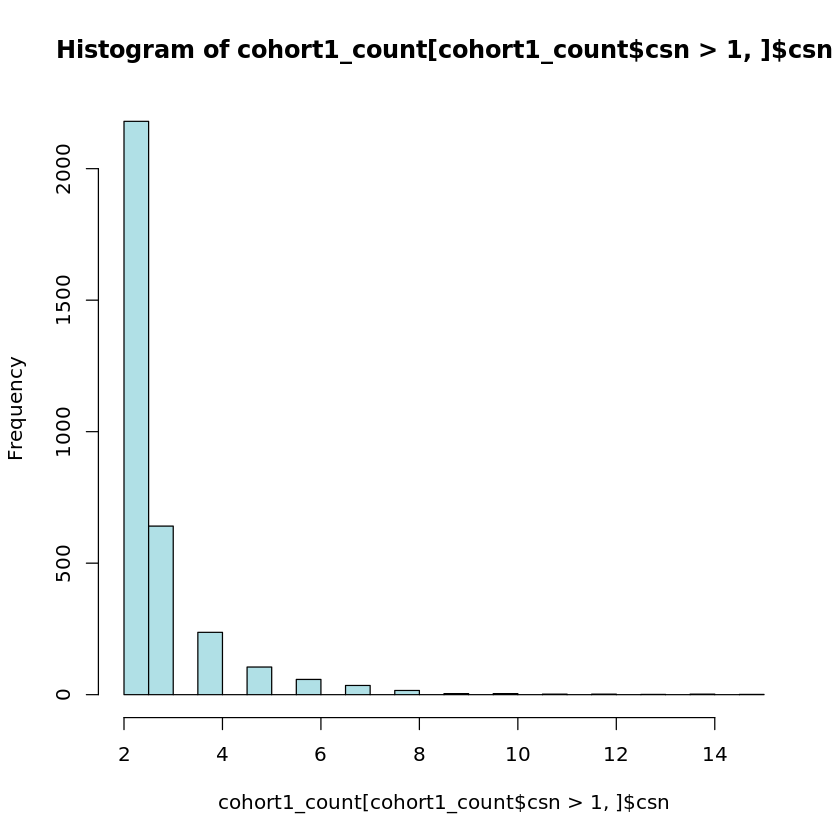

In [9]:
# count how many visits/csn each MRN (anon_id) has
cohort1_count <- cohort1 %>% count(anon_id, sort = TRUE, name = 'csn')
nrow(cohort1_count)
summary(cohort1_count$csn)

# display histogram of freq of patients who have more than 1 visit
hist(cohort1_count[cohort1_count$csn >1, ]$csn, breaks=38, col="powderblue")

In [10]:
head(cohort1_count)

,anon_id,csn
,<chr>,<int>
1,JC1571693,15
2,JC1620363,14
3,JC2172285,14
4,JC1777634,13
5,JC2782774,12
6,JC518294,12


### Encounter, hospital, inpatient IDs

Errors on pat_csn (all NA if SQL is run here in R)

Run `data_BQ/m1_encounter.sql`, output is `encounters.csv`

* This table gives us the inpatient id and ESI level
* Either Hospital encounter or empty (NA) type: only keep Hospital Encounter
* All Visit type are NA, as this might be more applicable to outpatient encounters
* Acuity levels are ESI with some missing (~2200)

==> we can remove enc_type and visit_type
* Hospital Admission time (such as ED arrival) is probably before the admit time (to inpatient) from order proc
* Admit time from init cohort is effective_time_jittered_utc, same as Hospital admission time, all times are UTC

In [11]:
# data from 04/2020 - 2021
datadir6 = "../../DataTD/validation"
enc <- read.csv(file.path(datadir6, "encounters_2021.csv"))
nrow(enc)

[1] 23357

In [12]:
enc %>% filter(is.na(inpatient_data_id_coded))

anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,inpatient_data_id_coded,enc_type,visit_type,acuity_level,ACUITY_LEVEL_C,hosp_admsn_time_jittered_utc
<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<lgl>,<chr>,<dbl>,<chr>


In [13]:
enc %>% gather(var, value) %>% distinct() %>% count(var) %>% arrange(n)

var,n
<chr>,<int>
enc_type,1
visit_type,1
label,2
acuity_level,6
ACUITY_LEVEL_C,6
anon_id,16908
admit_time_jittered,22953
hosp_admsn_time_jittered_utc,22973
inpatient_data_id_coded,23357


In [14]:
summary(enc %>% select(acuity_level, enc_type, visit_type))
summary(enc$ACUITY_LEVEL_C)

# if summary doesn't display (not factor), use table
apply(enc[c("acuity_level", "enc_type", "visit_type")], 2, table)

 acuity_level         enc_type         visit_type    
 Length:23357       Length:23357       Mode:logical  
 Class :character   Class :character   NA's:23357    
 Mode  :character   Mode  :character                 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    2.00    3.00    2.54    3.00    5.00     159 

$acuity_level

                1-Resuscitation      2-Emergent        3-Urgent   4-Semi-Urgent 
            159             725            9461           12793             208 
   5-Non-Urgent 
             11 

$enc_type

Hospital Encounter 
             23357 

$visit_type
< table of extent 0 >


In [15]:
# tables
enc %>% group_by(enc_type) %>% count()
enc %>% group_by(acuity_level) %>% count()
enc %>% group_by(ACUITY_LEVEL_C, acuity_level) %>% count()

enc_type,n
<chr>,<int>
Hospital Encounter,23357


acuity_level,n
<chr>,<int>
,159
1-Resuscitation,725
2-Emergent,9461
3-Urgent,12793
4-Semi-Urgent,208
5-Non-Urgent,11


ACUITY_LEVEL_C,acuity_level,n
<dbl>,<chr>,<int>
1,1-Resuscitation,725
2,2-Emergent,9461
3,3-Urgent,12793
4,4-Semi-Urgent,208
5,5-Non-Urgent,11
NA,,159


In [16]:
head(enc, 1)
head(cohort1, 1)

,anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,inpatient_data_id_coded,enc_type,visit_type,acuity_level,ACUITY_LEVEL_C,hosp_admsn_time_jittered_utc
,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<lgl>,<chr>,<dbl>,<chr>
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,57868578,Hospital Encounter,NA,3-Urgent,3,2020-09-29 16:02:00+00:00


,anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,admit_time,adm_year,adm_month
,<chr>,<dbl>,<chr>,<int>,<dttm>,<dbl>,<dbl>
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,2020-09-29 22:45:00,2020,9


Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] 20338

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.350   3.433   4.151   4.917 145.067 

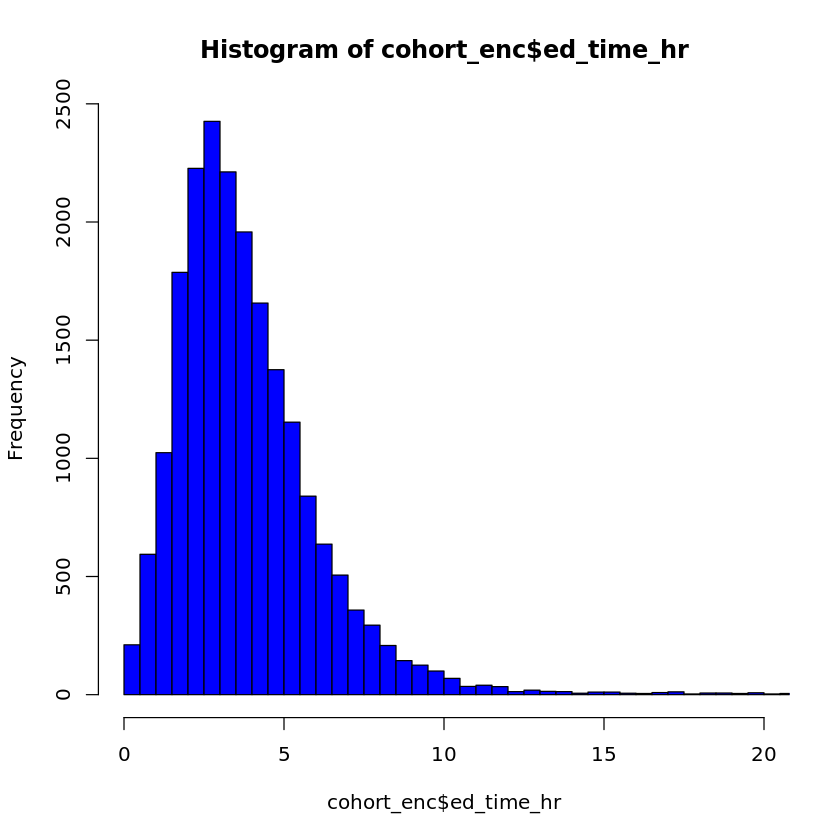

In [17]:
# join the encounter table with cohort table to get the inpatient data id coded
# removed those empty encounter type (18), only Hospital Encounter left
enc <- enc %>% filter(enc_type == "Hospital Encounter") %>%
                select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, 
                       ESI = ACUITY_LEVEL_C, hosp_admsn_time = hosp_admsn_time_jittered_utc) %>% 
                mutate(hosp_admsn_time = ymd_hms(hosp_admsn_time))

cohort_enc <- inner_join(cohort1, enc) %>% 
            mutate(ed_time_hr = as.numeric(difftime(admit_time, hosp_admsn_time, units ="hours")))

nrow(cohort_enc)
summary(cohort_enc$ed_time_hr)
hist(cohort_enc$ed_time_hr, xlim=c(0, 20), breaks=300, col="blue")

### Code status

* Process code status: keep patients whose code status is Full prior to admission or within 24 hour after admission. Otherwise interventions might not match with presentations.
* In other words: remove patients whose have a code status not FULL, anytime before admission or within 24 hour after admission 
* Note that in the display_name, some codes are blank but they are converted to something in description --> use description

In [18]:
# codestatus.csv is from querying code status order from order_proc
code <- read.csv(file.path(datadir6, "code_status_2021.csv")) 
nrow(code) #
summary(code %>% select(order_status, display_name, description))

# if summary doesn't display (not factor), use table
apply(code[c("order_status", "display_name", "description")], 2, table)

[1] 71667

 order_status       display_name       description       
 Length:71667       Length:71667       Length:71667      
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  

$order_status

         Canceled     Sent 
      19    71640        8 

$display_name

DNR/Comfort Care          DNR/DNE          DNR/DNI        Full Code 
            3121             2017            10511            53295 
    Partial Code 
            2723 

$description

DNR/COMFORT CARE          DNR/DNE          DNR/DNI        FULL CODE 
            3121             2017            10511            53295 
    PARTIAL CODE 
            2723 


In [19]:
# tables
code %>% group_by(order_status) %>% count()
code %>% group_by(display_name) %>% count()
code %>% group_by(description) %>% count()

order_status,n
<chr>,<int>
,19
Canceled,71640
Sent,8


display_name,n
<chr>,<int>
DNR/Comfort Care,3121
DNR/DNE,2017
DNR/DNI,10511
Full Code,53295
Partial Code,2723


description,n
<chr>,<int>
DNR/COMFORT CARE,3121
DNR/DNE,2017
DNR/DNI,10511
FULL CODE,53295
PARTIAL CODE,2723


In [20]:
head(code, n=1) 

,anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,order_type,order_status,display_name,description,order_time_jittered_utc
,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,Code Status,Canceled,Full Code,FULL CODE,2020-09-30 01:24:00+00:00


In [21]:
code <- code %>% select(anon_id, pat_enc_csn_id_coded, description, order_time = order_time_jittered_utc) %>% 
                    mutate(order_time = ymd_hms(order_time),
                           description = factor(description)) %>% distinct() 
nrow(code) 
summary(code) 

[1] 34796

   anon_id          pat_enc_csn_id_coded           description   
 Length:34796       Min.   :1.313e+11    DNR/COMFORT CARE: 1625  
 Class :character   1st Qu.:1.313e+11    DNR/DNE         : 1017  
 Mode  :character   Median :1.313e+11    DNR/DNI         : 5218  
                    Mean   :1.313e+11    FULL CODE       :25642  
                    3rd Qu.:1.313e+11    PARTIAL CODE    : 1294  
                    Max.   :1.313e+11                            
   order_time                 
 Min.   :2018-04-22 22:27:00  
 1st Qu.:2020-07-01 18:13:30  
 Median :2020-12-11 03:00:00  
 Mean   :2020-12-02 12:41:17  
 3rd Qu.:2021-05-15 07:44:15  
 Max.   :2021-09-30 07:00:00  

In [22]:
# calculate the difference btwn admit time and code status order time
code <- left_join(cohort_enc, code) %>% 
            mutate(code_diff_hr = as.numeric(difftime(order_time, admit_time, units = 'hours')))

nrow(code %>% group_by(anon_id, pat_enc_csn_id_coded) %>% unique()) # 
nrow(code %>% select(anon_id, pat_enc_csn_id_coded) %>% group_by(anon_id, pat_enc_csn_id_coded) %>% unique()) #

Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] 31813

[1] 20338

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
 -29.983    1.617    2.967   47.404   22.000 3038.267     1574 

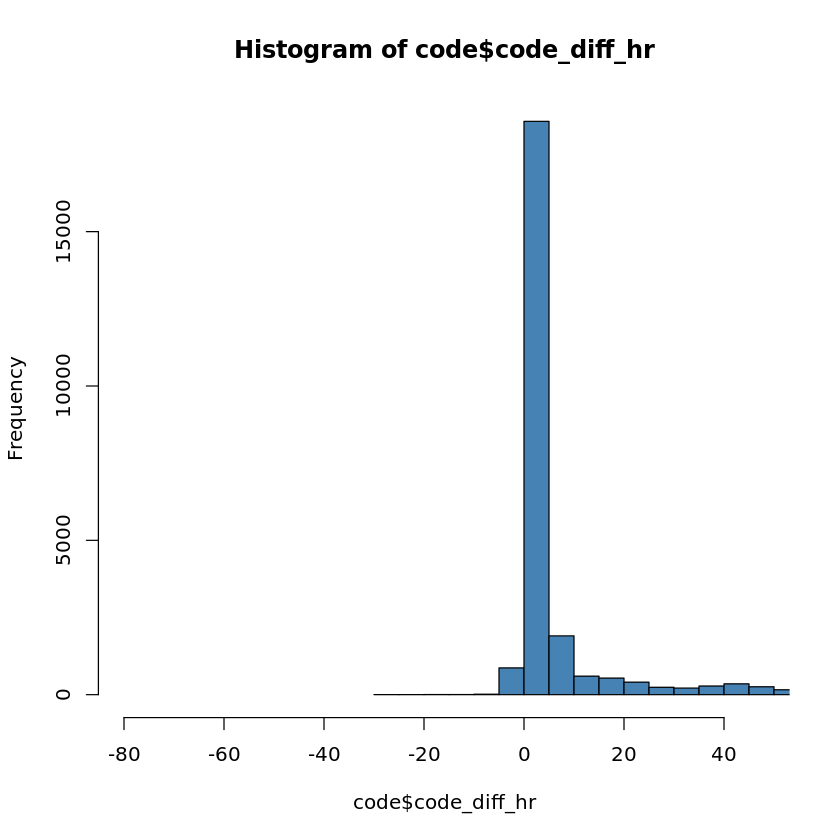

In [23]:
# code order time is prior to or within 24 hours after admission, time diff in hours (code time - admit time)
summary(code$code_diff_hr)
hist(code$code_diff_hr,  xlim=c(-80, 48), breaks=720, col="steelblue")

In [24]:
# number of patients whose code status are either full or na (if exists, consider na = FULL) 
nrow(filter(code, description != "FULL CODE" & !is.na(description))) # to be removed

# cohort of patients whose code status before admission or 24 hour after admission is not FULL CODE
code_notfull <- code %>% 
                filter(code_diff_hr <=24 & description != "FULL CODE" & !is.na(description)) %>% 
                select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, admit_time) %>%
                distinct()

# number of patients whose code status is not full 24
nrow(code_notfull) # 
nrow(code_notfull %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) # 9022

[1] 7891

[1] 3178

[1] 3178

In [25]:
# remove 3179 non-fullcode, non-na code patients from the cohort
cohort_code <- anti_join(cohort_enc, code_notfull) 
nrow(cohort_code) #
nrow(unique(cohort_code %>% select(anon_id, pat_enc_csn_id_coded))) 
nrow(filter(cohort_code, is.na(admit_time)))

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "inpatient_data_id_coded")



[1] 17160

[1] 17160

[1] 0

In [26]:
head(cohort_code, n=1)

,anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,admit_time,adm_year,adm_month,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr
,<chr>,<dbl>,<chr>,<int>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,2020-09-29 22:45:00,2020,9,57868578,3,2020-09-29 16:02:00,6.716667


### Age from demographic variables
1. Age (only >=18)
2. insurance = Medical/care/caid and n/a insurance --> medis =1 otherwise 0
3. language --> Engl = 1 for English, otherwise 0
4. leave height and weight to be processed with flowsheet age (>=18 only)

In [27]:
demo <- read.csv(file.path(datadir6, "demographics_2021.csv")) %>% distinct()
nrow(demo) #
summary(demo)

[1] 16907

   anon_id             gender              race             language        
 Length:16907       Length:16907       Length:16907       Length:16907      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
 recent_height_cm recent_weight_kg  insurance             dob           
 Min.   : 39.0    Min.   :  1.00   Length:16907       Length:16907      
 1st Qu.:160.0    1st Qu.: 60.30   Class :character   Class :character  
 Median :167.6    Median : 72.80   Mode  :character   Mode  :character  
 Mean   :167.4    Mean   : 76.04                                        
 3rd Qu.:175.3    3

In [28]:
head(demo)

,anon_id,gender,race,language,recent_height_cm,recent_weight_kg,insurance,dob
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,JC1000116,Female,Other,Spanish,154.00,73.05,HPSM,1977-01-23
2,JC1000939,Female,Other,Spanish,154.94,136.80,HPSM,1971-08-26
3,JC1001115,Female,White,English,157.48,60.60,MEDICARE,1928-11-12
4,JC1001580,Male,White,English,187.96,89.12,UNITED HEALTHCARE,1967-03-27
5,JC1001688,Male,Asian,English,205.74,163.29,ALAMEDA ALLIANCE MCAL MGD CARE,1983-11-02
6,JC1001762,Male,White,English,174.00,83.90,MEDICARE,1931-03-28


In [29]:
# calculate age, only keep patients age >=18, (304 < 18)
cohort_age <- left_join(cohort_code, demo) %>%
                    mutate(dob = ymd(dob), gender = factor(gender), 
                           race = factor(race), language = factor(language), insurance = factor(insurance),
                           age = round(as.numeric(difftime(ymd_hms(admit_time), dob, units="days")/365),0)) %>%
                    filter(age >= 18) %>% select(-dob)
nrow(cohort_age) #45796 vs 45794
summary(cohort_age)

Joining, by = "anon_id"



[1] 17128

   anon_id          pat_enc_csn_id_coded admit_time_jittered     label       
 Length:17128       Min.   :1.313e+11    Length:17128        Min.   :0.0000  
 Class :character   1st Qu.:1.313e+11    Class :character    1st Qu.:0.0000  
 Mode  :character   Median :1.313e+11    Mode  :character    Median :0.0000  
                    Mean   :1.313e+11                        Mean   :0.1388  
                    3rd Qu.:1.313e+11                        3rd Qu.:0.0000  
                    Max.   :1.313e+11                        Max.   :1.0000  
                                                                             
   admit_time                     adm_year      adm_month     
 Min.   :2020-04-01 00:45:00   Min.   :2020   Min.   : 1.000  
 1st Qu.:2020-09-04 19:02:45   1st Qu.:2020   1st Qu.: 4.000  
 Median :2021-01-22 20:46:00   Median :2021   Median : 7.000  
 Mean   :2021-01-17 12:41:44   Mean   :2021   Mean   : 6.612  
 3rd Qu.:2021-06-07 08:13:15   3rd Qu.:2021   3rd Qu.: 9.000 

In [30]:
# checking duplicates
nrow(cohort_age %>% select(anon_id) %>% distinct()) # 31513 vs 31511
nrow(cohort_age %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) # 45796 vs 45794
cohort_age[duplicated(cohort_age[, c('anon_id','pat_enc_csn_id_coded')]),]

# cohort_demo %>% filter(anon_id == "JCd49287") # pat_enc_csn_id_coded = 131195706986, 
# cohort_demo <- cohort_demo %>% filter (!(anon_id == "JCd49287" & race == "Unknown"))

[1] 12991

[1] 17128

anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,admit_time,adm_year,adm_month,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,age
<chr>,<dbl>,<chr>,<int>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>


In [31]:
summary(cohort_age %>% select(ESI, gender, race, recent_height_cm, recent_weight_kg, age))
cohort_age %>% gather(var, value) %>% distinct() %>% count(var) %>% arrange(n)
cohort_age %>% summarise_each(funs(n_distinct))
# cohort_demo %>% summarise(across(all_of(.), count))

      ESI          gender                   race      recent_height_cm
 Min.   :1.00   Female:8055   Asian           :2788   Min.   :113.0   
 1st Qu.:2.00   Male  :9073   Black           :1109   1st Qu.:160.0   
 Median :3.00                 Native American :  64   Median :167.6   
 Mean   :2.55                 Other           :4521   Mean   :168.0   
 3rd Qu.:3.00                 Pacific Islander: 366   3rd Qu.:175.3   
 Max.   :5.00                 Unknown         :  87   Max.   :213.4   
 NA's   :98                   White           :8193   NA's   :387     
 recent_weight_kg      age        
 Min.   : 26.76   Min.   : 18.00  
 1st Qu.: 61.23   1st Qu.: 46.00  
 Median : 74.00   Median : 62.00  
 Mean   : 77.22   Mean   : 59.72  
 3rd Qu.: 88.50   3rd Qu.: 74.00  
 Max.   :342.46   Max.   :107.00  
 NA's   :30                       

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


var,n
<chr>,<int>
adm_year,2
gender,2
label,2
ESI,6
race,7
adm_month,12
language,47
age,87
insurance,91


Warning message:
“`summarise_each_()` was deprecated in dplyr 0.7.0.
Please use `across()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,admit_time,adm_year,adm_month,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,age
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
12991,17128,16867,2,16867,2,12,17128,6,16891,962,2,7,47,573,2483,91,87


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.00   46.00   62.00   59.72   74.00  107.00 

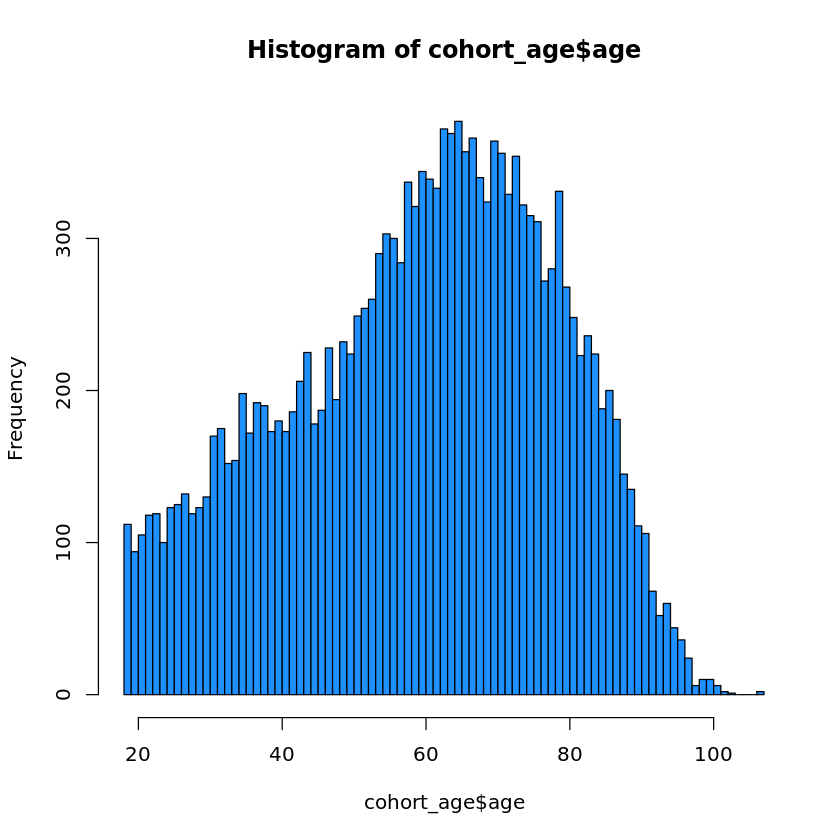

In [32]:
summary(cohort_age$age)
hist(cohort_age$age, breaks=100, col="dodgerblue")

In [33]:
# this is the updated cohort meeting encounter/codestatus/age criteria
# save to 6_validation folder
write.csv(cohort_age, file = file.path(valdir, "6_2_cohort2.csv"), row.names=FALSE)

In [34]:
head(cohort_age)

,anon_id,pat_enc_csn_id_coded,admit_time_jittered,label,admit_time,adm_year,adm_month,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,age
,<chr>,<dbl>,<chr>,<int>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
1,JC1000116,131295313275,2020-09-29 22:45:00+00:00,0,2020-09-29 22:45:00,2020,9,57868578,3,2020-09-29 16:02:00,6.716667,Female,Other,Spanish,154.00,73.05,HPSM,44
2,JC1000939,131295018112,2020-08-22 11:41:00+00:00,1,2020-08-22 11:41:00,2020,8,57698292,2,2020-08-22 07:47:00,3.900000,Female,Other,Spanish,154.94,136.80,HPSM,49
3,JC1001580,131300665918,2020-12-29 04:15:00+00:00,0,2020-12-29 04:15:00,2020,12,61108864,3,2020-12-29 02:58:00,1.283333,Male,White,English,187.96,89.12,UNITED HEALTHCARE,54
4,JC1001688,131288774622,2020-06-19 21:36:00+00:00,0,2020-06-19 21:36:00,2020,6,53810016,3,2020-06-19 19:45:00,1.850000,Male,Asian,English,205.74,163.29,ALAMEDA ALLIANCE MCAL MGD CARE,37
5,JC1001688,131302440087,2021-02-26 11:46:00+00:00,0,2021-02-26 11:46:00,2021,2,62198093,3,2021-02-26 09:12:00,2.566667,Male,Asian,English,205.74,163.29,ALAMEDA ALLIANCE MCAL MGD CARE,37
6,JC1001842,131305861173,2021-02-23 08:08:00+00:00,0,2021-02-23 08:08:00,2021,2,64314745,3,2021-02-23 05:08:00,3.000000,Male,Other,English,170.18,63.50,HPSM,20
